# Ensemble Learning and Random Forests


 A group of predictors is called an **ensemble**; thus, this technique is called **Ensemble Learning**, and an **Ensemble Learning algorithm is called an Ensemble method**.

For example, you can train a group of Decision Tree classifiers, each on a different random subset of the training set.

To make predictions,
+ You just obtain the predictions of all individual trees,
+ then predict the class that gets the most votes.

**Such an ensemble of Decision Trees is called a Random Forest**, and despite its simplicity, this is one of the most powerful Machine Learning algorithms available today.



## Voting Classifiers

![Training diverse classifiers](images/ensembles/training_diverse_classifiers.png)

A very simple way to create an even better classifier is to aggregate the predictions of each classifier and predict the class that gets the most votes. 
**This majority-vote classifier is called a hard voting classifier**.

![Hard voting classifier classification](images/ensembles/hard_voting.png)


Somewhat surprisingly, this voting classifier often achieves a higher accuracy than the best classifier in the ensemble.
+ In fact, even if each classifier is a weak learner (meaning it does only slightly better than random guessing), the ensemble can still be a strong learner (achieving high accuracy), 
+ provided there are a sufficient number of weak learners and they are sufficiently diverse.

Suppose if all the classifiers trained in the ensemble has a accuracy of 51% only. So to find the combined accuracy we want to find how many times each of the classifiers are correct.

For a binary classifier, running it n times the probability distribution will be the binomial series


**<sup>n</sup>C<sub>r</sub>a<sup>n-r</sup>b<sup>r</sup> **

 where n-r > r ie the power of a is greater than power of b

In [3]:
import numpy as np
def nCr(n, r):
    return np.math.factorial(n)//(np.math.factorial(r) * np.math.factorial(n-r))

In [4]:
prob = 0
from decimal import Decimal
for i in range(1, 500):
    prob += np.multiply(np.multiply(nCr(1000, i), Decimal(0.51 ** (1000-i))), Decimal(0.49 ** i))
    
prob 


Decimal('0.7260985557305041450334633096')

#### How is this possible ??

+ Suppose you have a slightly biased coin that has a 51% chance of coming up heads, 
+ and 49% chance of coming up tails. 
+ If you toss it 1,000 times, you will generally get more or less 510 heads and 490 tails, 
+ and hence a majority of heads. 

If you do the math, you will find that the probability of obtaining a majority of heads after 1,000 tosses is close to 75%. The more you toss the coin, the higher the probability (e.g., with 10,000 tosses, the probability climbs over 97%). This is due to the law of large numbers: as you keep tossing the coin, the ratio of heads gets closer and closer to the probability of heads (51%). 

Below figure shows 10 series of biased coin tosses. You can see that as the number of tosses increases, the ratio of heads approaches 51%. Eventually all 10 series end up so close to 51% that they are consistently above 50%.


#### Lets prepare with common imports and settings

In [5]:
# Common imports
import numpy as np
import matplotlib.pyplot as plt
import os

# setting random seed
np.random.seed(42)


# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12


CHAPTER_ID = "ensembles"

def image_path(fig_id):
    
    if os.path.exists(os.path.join("images", CHAPTER_ID)):
        return os.path.join("images", CHAPTER_ID, fig_id)
    os.mkdir(os.path.join("images", CHAPTER_ID))
    return os.path.join("images", CHAPTER_ID, fig_id)

def save_fig(fig_id, tight_layout=True):
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(image_path(fig_id) + ".png", format='png', dpi=300)

In [6]:
heads_proba = 0.51 # The probability of head is 0.51 as it is a biased coin

# coin_tosses contains the coin tosses for 10 series of 10000 times of coin tosses
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32) 
cumulative_sum_of_number_of_heads = np.cumsum(coin_tosses, axis=0)
cumulative_heads_ratio = cumulative_sum_of_number_of_heads / np.arange(1, 10001).reshape(-1, 1)
cumulative_heads_ratio


array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [1.        , 0.        , 0.        , ..., 0.        , 0.5       ,
        0.5       ],
       [0.66666667, 0.33333333, 0.33333333, ..., 0.        , 0.33333333,
        0.66666667],
       ...,
       [0.51140228, 0.5115023 , 0.50680136, ..., 0.5095019 , 0.51070214,
        0.51010202],
       [0.51135114, 0.51145115, 0.50685069, ..., 0.50955096, 0.51075108,
        0.51015102],
       [0.5113    , 0.5115    , 0.5068    , ..., 0.5095    , 0.5108    ,
        0.5102    ]])

#### Now let's visualize that the probability reaches 51 with increasing number of trials

Saving figure law_of_large_numbers_plot


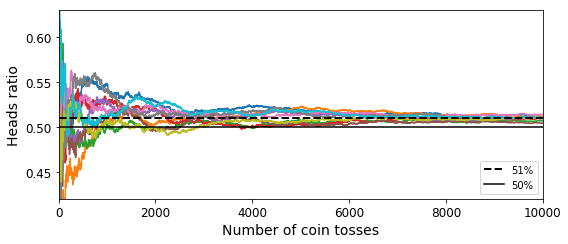

In [7]:
plt.figure(figsize=(8, 3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.63])
save_fig("law_of_large_numbers_plot")
plt.show()


Ensemble methods work best when the predictors are 

+ As independent from one another as possible. 
+ One way to get diverse classifiers is to train them using very different algorithms. 
+ This increases the chance that they will make very different types of errors, improving the ensemble’s accuracy.


Let's train a voting classifier and check if it performs better than the individual classifiers

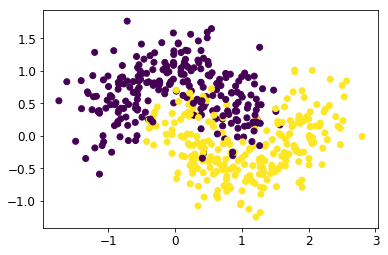

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

plt.scatter(X[:,0], X[:, 1], c=y)


In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomFor...f',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=1, voting='hard', weights=None)

In [10]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.896


/Users/shahrukh/Code/Work/Cxl_Notebooks/env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


**The voting classifier slightly outperforms all the individual classifiers.**


## Hard voting and Soft voting

+ If all classifiers are able to **estimate class probabilities (i.e., they have a predict_proba() method)**, then you can tell Scikit-Learn **to predict the class with the highest class probability, averaged over all the individual classifiers. This is called soft voting.**

+ It often achieves higher performance than hard voting because it gives more weight to highly confident votes. All you need to do is replace voting="hard" with voting="soft" and ensure that all classifiers can estimate class probabilities. 

+ This is not the case of the SVC class by default, so you need to set its probability hyperparameter to True (this will make the SVC class use cross-validation to estimate class probabilities, slowing down training, and it will add a predict_proba() method). 

Let us modify the preceding code to use soft voting, you will find that the voting classifier achieves over 91% accuracy!

In [11]:
log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(random_state=42, probability=True)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomFor...bf',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None)

In [12]:
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.912


/Users/shahrukh/Code/Work/Cxl_Notebooks/env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


## Bagging and Pasting

+ One way to get a diverse set of classifiers is to use very different training algorithms, as just discussed.
+ Another approach is to use the same training algorithm for every predictor, but to train them on different random subsets of the training set. 


+ When sampling **is performed with replacement, this method is called bagging (short for bootstrap aggregating2)**. 
+ When sampling **is performed without replacement, it is called pasting**.


In other words, both bagging and pasting allow training instances to be sampled several times across multiple predictors, but only bagging allows training instances to be sampled several times for the same predictor

![Pasting and Bagging](images/ensembles/pasting_bagging.png)

+ Once all predictors are trained, the ensemble can make a prediction for a new instance by simply aggregating the predictions of all predictors.
+ The aggregation function is typically the statistical mode (i.e., the most frequent prediction, just like a hard voting classifier) for classification, or the average for regression.

Each individual predictor has a higher bias than if it were trained on the original training set, but aggregation reduces both bias and variance. Generally, the net result is that the ensemble has a similar bias but a lower variance than a single predictor trained on the original training set.


**As you can see in Figure 7-4, predictors can all be trained in parallel, via different CPU cores or even different servers. Similarly, predictions can be made in parallel. This is one of the reasons why bagging and pasting are such popular methods: they scale very well.**

The following code trains an ensemble of 500 Decision Tree classifiers, each trained on 100 training instances randomly sampled from **the training set with replacement (this is an example of bagging, but if you want to use pasting instead, just set bootstrap=False)**.


The n_jobs parameter tells Scikit-Learn the **number of CPU cores to use for training and predictions (–1 tells Scikit-Learn to use all available cores)**:

In [13]:
from sklearn.ensemble import BaggingClassifier 
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier( 
    DecisionTreeClassifier(), 
    n_estimators=500, 
    max_samples=100, 
    bootstrap=True, 
    n_jobs=-1
)

bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

**The BaggingClassifier automatically performs soft voting instead of hard voting if the base classifier can estimate class probabilities (i.e., if it has a predict_proba() method), which is the case with Decision Trees classifiers.**

As you can see, the ensemble’s predictions will likely generalize much better than the single Decision Tree’s predictions: the ensemble has a comparable bias but a smaller variance (it makes roughly the same number of errors on the training set, but the decision boundary is less irregular).

In [14]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.92


whereas for the individual tree we have

In [15]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


Let's visualize how the Bagging classifier generalizes well on the data

In [16]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap, linewidth=10)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

/Users/shahrukh/Code/Work/Cxl_Notebooks/env/lib/python3.6/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)


Saving figure decision_tree_without_and_with_bagging_plot


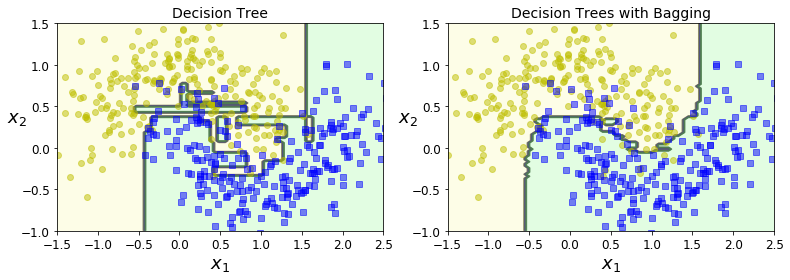

In [17]:
plt.figure(figsize=(11,4))
plt.subplot(121)
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.subplot(122)
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
save_fig("decision_tree_without_and_with_bagging_plot")
plt.show()

Bootstrapping introduces a bit more diversity in the subsets that each predictor is trained on, so bagging ends up with a slightly higher bias than pasting, but this also means that predictors end up being less correlated so the ensemble’s variance is reduced. 

Overall, bagging often results in better models, which explains why it is generally preferred.

## Out of Bag Evaluation

With bagging, some instances may be sampled several times for any given predictor, while others may not be sampled at all. 
**By default a BaggingClassifier samples m training instances with replacement (bootstrap=True), where m is the size of the training set**


This means that only about 63% of the training instances are sampled on average for each predictor. 
**As m grows, this ratio approaches 1 – exp(–1) ≈ 63.212%.**
The remaining 37% of the training instances that are not sampled are called out-of-bag (oob) instances. Note that they are not the same 37% for all predictors.


**Since a predictor never sees the oob instances during training, it can be evaluated on these instances, without the need for a separate validation set or cross-validation. You can evaluate the ensemble itself by averaging out the oob evaluations of each predictor.
In Scikit-Learn, you can set oob_score=True when creating a BaggingClassifier to request an
automatic oob evaluation after training. **

The following code demonstrates this. The resulting evaluation score is available through the **oob\_score\_** variable:

In [18]:
bag_clf = BaggingClassifier( 
    DecisionTreeClassifier(), 
    n_estimators=500, 
    bootstrap=True, 
    n_jobs=-1, 
    oob_score=True)
bag_clf.fit(X_train, y_train) 
bag_clf.oob_score_

0.8933333333333333

In [19]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)


0.92

In [20]:
bag_clf.oob_decision_function_

array([[0.34536082, 0.65463918],
       [0.41621622, 0.58378378],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.07303371, 0.92696629],
       [0.4       , 0.6       ],
       [0.01530612, 0.98469388],
       [1.        , 0.        ],
       [0.99428571, 0.00571429],
       [0.77297297, 0.22702703],
       [0.        , 1.        ],
       [0.75842697, 0.24157303],
       [0.82539683, 0.17460317],
       [0.96610169, 0.03389831],
       [0.06358382, 0.93641618],
       [0.00574713, 0.99425287],
       [0.96590909, 0.03409091],
       [0.94152047, 0.05847953],
       [0.9787234 , 0.0212766 ],
       [0.03508772, 0.96491228],
       [0.36612022, 0.63387978],
       [0.8972973 , 0.1027027 ],
       [1.        , 0.        ],
       [0.96590909, 0.03409091],
       [0.        , 1.        ],
       [0.99470899, 0.00529101],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.75280899, 0.24719101],
       [0.

## Random Forests

In [21]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter="random", max_leaf_nodes=16, random_state=42),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1, random_state=42)


In [22]:
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [23]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

In [24]:
np.sum(y_pred == y_pred_rf) / len(y_pred)  # almost identical predictions


0.976

### Extra Trees

In [25]:
from sklearn.ensemble import ExtraTreesClassifier

extra_tree_clf = ExtraTreesClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)
extra_tree_clf.fit(X_train, y_train)
y_pred_extra_trees = extra_tree_clf.predict(X_test)

In [26]:
np.sum(y_pred == y_pred_extra_trees) / len(y_pred)

0.992

### Feature Importances

In [27]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876374
sepal width (cm) 0.023119288282510326
petal length (cm) 0.44103046436395765
petal width (cm) 0.4233579963547681


In [28]:
rnd_clf.feature_importances_


array([0.11249225, 0.02311929, 0.44103046, 0.423358  ])

/Users/shahrukh/Code/Work/Cxl_Notebooks/env/lib/python3.6/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)


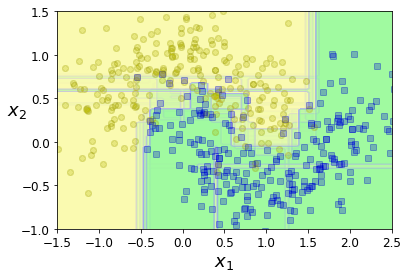

In [29]:
plt.figure(figsize=(6, 4))

for i in range(15):
    tree_clf = DecisionTreeClassifier(max_leaf_nodes=16, random_state=42 + i)
    indices_with_replacement = np.random.randint(0, len(X_train), len(X_train))
    tree_clf.fit(X[indices_with_replacement], y[indices_with_replacement])
    plot_decision_boundary(tree_clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.02, contour=False)

plt.show()

In [30]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')

In [31]:
rnd_clf = RandomForestClassifier(random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [32]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.hot,
               interpolation="nearest")
    plt.axis("off")

Saving figure mnist_feature_importance_plot


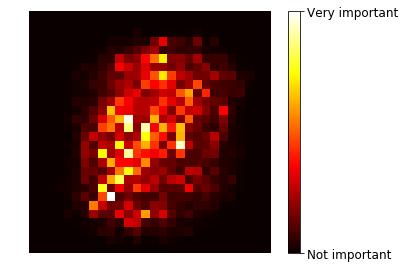

In [33]:

plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

save_fig("mnist_feature_importance_plot")
plt.show()

## AdaBoost

In [34]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.5, n_estimators=200, random_state=42)

/Users/shahrukh/Code/Work/Cxl_Notebooks/env/lib/python3.6/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)


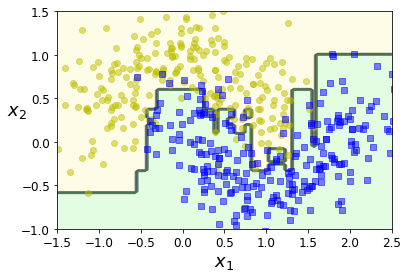

In [35]:
plot_decision_boundary(ada_clf, X, y)


/Users/shahrukh/Code/Work/Cxl_Notebooks/env/lib/python3.6/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)
/Users/shahrukh/Code/Work/Cxl_Notebooks/env/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Saving figure boosting_plot


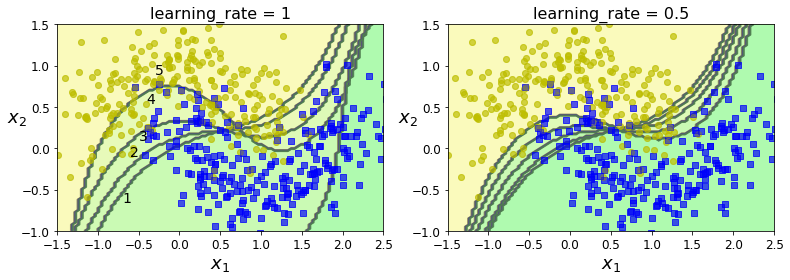

In [36]:

m = len(X_train)

plt.figure(figsize=(11, 4))
for subplot, learning_rate in ((121, 1), (122, 0.5)):
    sample_weights = np.ones(m)
    for i in range(5):
        plt.subplot(subplot)
        svm_clf = SVC(kernel="rbf", C=0.05, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights)
        y_pred = svm_clf.predict(X_train)
        sample_weights[y_pred != y_train] *= (1 + learning_rate)
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)

plt.subplot(121)
plt.text(-0.7, -0.65, "1", fontsize=14)
plt.text(-0.6, -0.10, "2", fontsize=14)
plt.text(-0.5,  0.10, "3", fontsize=14)
plt.text(-0.4,  0.55, "4", fontsize=14)
plt.text(-0.3,  0.90, "5", fontsize=14)
save_fig("boosting_plot")
plt.show()

In [37]:
list(m for m in dir(ada_clf) if not m.startswith("_") and m.endswith("_"))


['base_estimator_',
 'classes_',
 'estimator_errors_',
 'estimator_weights_',
 'estimators_',
 'feature_importances_',
 'n_classes_']

## Gradient Boosting

In [38]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [39]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

In [40]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

In [41]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

In [42]:
X_new = np.array([[0.8]])


In [43]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))


In [44]:
y_pred


array([0.75026781])

Saving figure gradient_boosting_plot


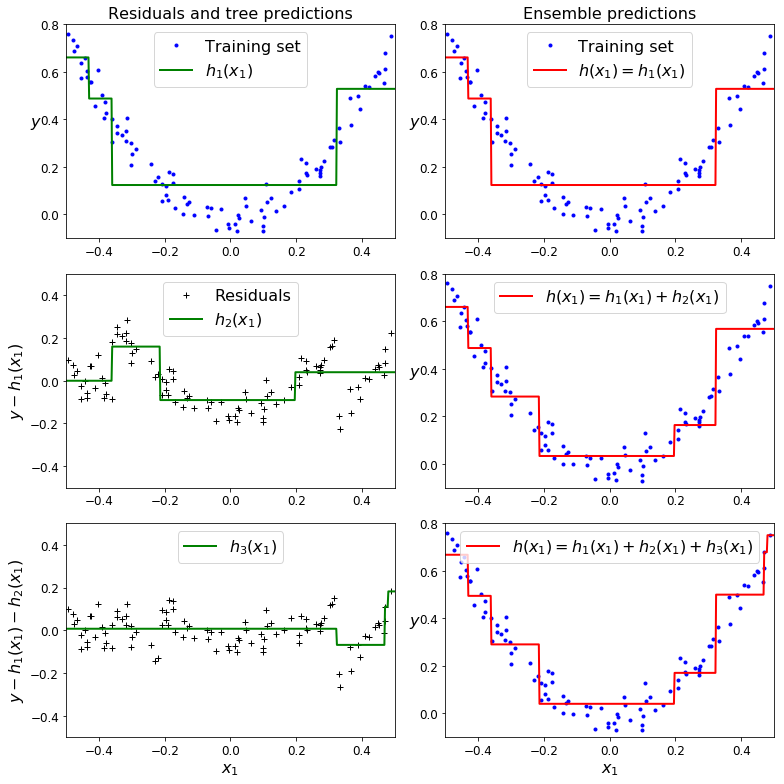

In [45]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

save_fig("gradient_boosting_plot")
plt.show()

In [46]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=1.0, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=3, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False)

In [47]:

gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=200, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False)

Saving figure gbrt_learning_rate_plot


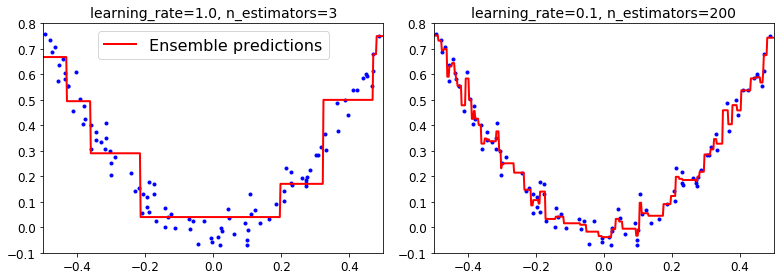

In [48]:

plt.figure(figsize=(11,4))

plt.subplot(121)
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)

save_fig("gbrt_learning_rate_plot")
plt.show()